# 评价方法分类
- 主观赋权法：综合指数法、模糊综合评判法、层次分析法、功效系数法
- 客观赋权法：主成分分析法、因子分析法、理想解法(TOPSIS)
# TOPSIS
## 定义
一种多指标评价方法，构造最优解和最劣解，通过计算到理想方案的贴近度来对方案进行排序，选出最佳方案。
## 步骤
1. 将数据变成**效益性数据**后用**向量规范化**的方法求规范决策矩阵$B=(b_{ij})_{m\times n}$
$$b_{ij}=a_{ij}/\sqrt {\sum \limits_{i-1}^m a_{ij}^2 }$$
2. 构成加权规范化矩阵$C$
$$c_{ij}=w_{ij}\cdot b_{ij}$$
3. 确定正理想解$C^*$和负理想解$C^0$
4. 计算各方案到正理想解$s_i^*$与负理想解的距离$s_i^0$
5. 计算各方案的排队指标值$$f_i^*=s_i^0/(s_i^0+s_i^*)$$
6. 按$f_i^*$由大到小排列方案的优劣次序
## 属性规范化方法
1. 线性变换$$b_{ij}=a_{ij}/a_j^{max}$$
2. 标准0-1变换$$b_{ij}=\frac {a_{ij}-a_{ij}^{min}}{a_{ij}^{max}-a_{ij}^{min}} $$
3. 区间型属性变换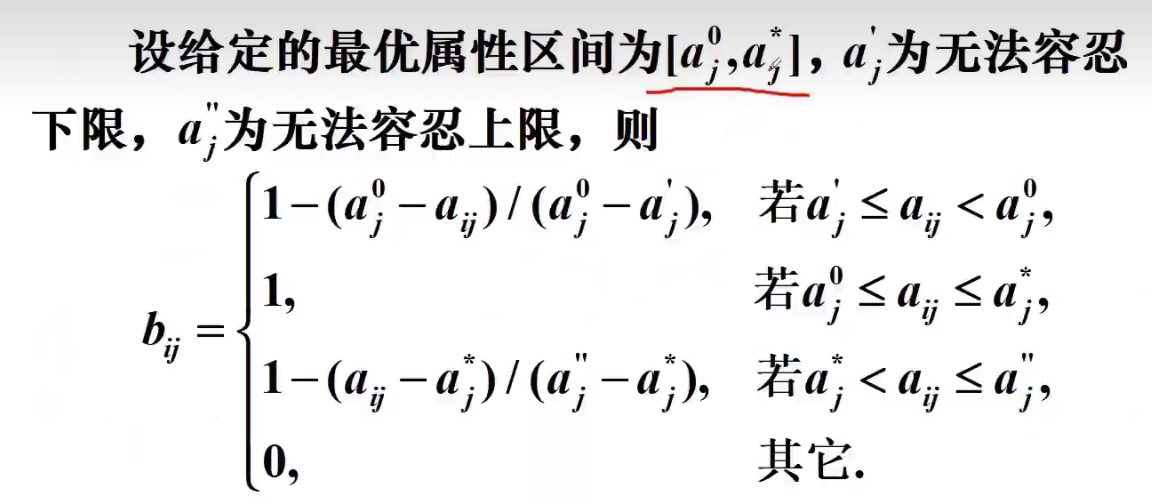
4. 向量规范化$$b_{ij}=a_{ij}/\sqrt {\sum \limits_{i-1}^m a_{ij}^2 }$$
5. 标准化处理$$b_{ij}=\frac {a_{ij}-\overline a_j}{s_j}$$
# 例题
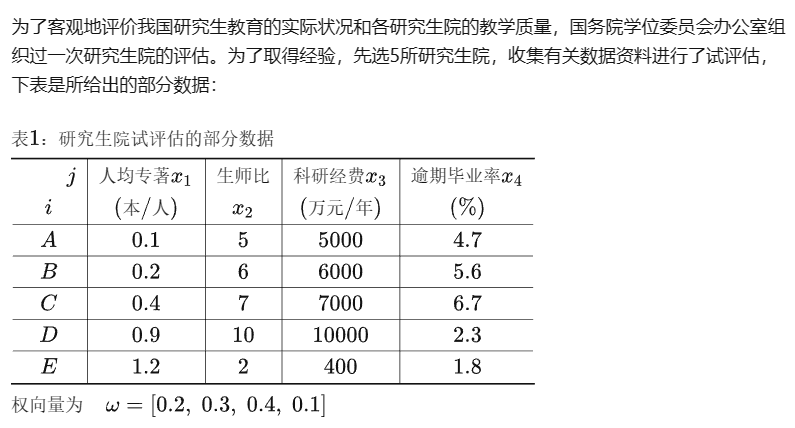




In [10]:
import pandas as pd
import numpy as np

# 指标属性同向化

    # 极小型指标（成本型）
def dataDirection_1(datas, offset=0):
	def normalization(data):
		return 1 / (data + offset)

	return list(map(normalization, datas))

    # 中间型指标
def dataDirection_2(datas, x_min, x_max):
	def normalization(data):
		if data <= x_min or data >= x_max:
			return 0
		elif data > x_min and data < (x_min + x_max) / 2:
			return 2 * (data - x_min) / (x_max - x_min)
		elif data < x_max and data >= (x_min + x_max) / 2:
			return 2 * (x_max - data) / (x_max - x_min)

	return list(map(normalization, datas))

    # 区间型指标
def dataDirection_3(datas, x_min, x_max, x_minimum, x_maximum):
	def normalization(data):
		if data >= x_min and data <= x_max:
			return 1
		elif data <= x_minimum or data >= x_maximum:
			return 0
		elif data > x_max and data < x_maximum:
			return 1 - (data - x_max) / (x_maximum - x_max)
		elif data < x_min and data > x_minimum:
			return 1 - (x_min - data) / (x_min - x_minimum)

	return list(map(normalization, datas))

def entropyWeight(data):
	data = np.array(data)
	# 归一化
	P = data / data.sum(axis=0)

	# 计算熵值
	E = np.nansum(-P * np.log(P) / np.log(len(data)), axis=0)

	# 计算权系数
	return (1 - E) / (1 - E).sum()

# TOPSIS模型
def topsis(data, weight=None):
	# 归一化
	data = data / np.sqrt((data ** 2).sum())

	# 最优最劣方案
	Z = pd.DataFrame([data.min(), data.max()], index=['负理想解', '正理想解'])

	# 距离
	weight = entropyWeight(data) if weight is None else np.array(weight)
	Result = data.copy()
	Result['正理想解'] = np.sqrt(((data - Z.loc['正理想解']) ** 2 * weight).sum(axis=1))
	Result['负理想解'] = np.sqrt(((data - Z.loc['负理想解']) ** 2 * weight).sum(axis=1))

	# 综合得分指数
	Result['综合得分指数'] = Result['负理想解'] / (Result['负理想解'] + Result['正理想解'])
	Result['排序'] = Result.rank(ascending=False)['综合得分指数']

	return Result, Z, weight


data = pd.DataFrame(
    {'人均专著': [0.1, 0.2, 0.4, 0.9, 1.2],
     '生师比': [5, 6, 7, 10, 2], 
     '科研经费': [5000, 6000, 7000, 10000, 400],
     '逾期毕业率': [4.7, 5.6, 6.7, 2.3, 1.8]}, 
     index=['院校' + i for i in list('ABCDE')])

data['生师比'] = dataDirection_3(data['生师比'], 5, 6, 2, 12)   # 师生比数据为区间型指标
data['逾期毕业率'] = dataDirection_1(data['逾期毕业率'])   # 逾期毕业率为极小型指标

out = topsis(data, weight=[0.2, 0.3, 0.4, 0.1])    # 设置权系数
print(out)

(         人均专著       生师比      科研经费     逾期毕业率      正理想解      负理想解    综合得分指数   排序
院校A  0.063758  0.597022  0.344901  0.275343  0.406984  0.384552  0.485830  4.0
院校B  0.127515  0.597022  0.413882  0.231092  0.368177  0.409360  0.526483  3.0
院校C  0.255031  0.497519  0.482862  0.193151  0.315879  0.405565  0.562158  2.0
院校D  0.573819  0.199007  0.689803  0.562658  0.239342  0.502968  0.677571  1.0
院校E  0.765092  0.000000  0.027592  0.718952  0.531357  0.354994  0.400512  5.0,           人均专著       生师比      科研经费     逾期毕业率
负理想解  0.063758  0.000000  0.027592  0.193151
正理想解  0.765092  0.597022  0.689803  0.718952, array([0.2, 0.3, 0.4, 0.1]))


>参考资料：\
>[1]https://zhuanlan.zhihu.com/p/37738503